## Gaussian filter prediction with vgg19_bn

### Predict part

In [1]:
import torch

In [7]:
from __future__ import print_function

import os
import sys
import random
from PIL import Image
import numpy as np

import scipy
import scipy.ndimage

In [2]:
mm = torch.load("torch_model_vgg19bn.bin")

In [3]:
mm.eval()

DataParallel(
  (module): DataParallel(
    (module): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace)
        (13): MaxPoo

In [4]:
path="img3/"

In [5]:
fname = "me.jpg"

In [6]:
box_size = 32

In [30]:
def border(img, height=2):
    h, w, c = img.shape

    im_bg = img
    #im_bg = (im_bg + 1) * 255  # e.g., make it white
    im_bg[:2,:,:] = np.zeros((2, w, c))
    im_bg[:,:2,:] = np.zeros((h, 2, c))
    im_bg[30:32,:,:] = np.zeros((2, w, c))
    im_bg[:,30:32,:] = np.zeros((h, 2, c))
    return img

In [38]:
images = []
fp = os.path.join(path, fname)
im = Image.open(fp)   
if im.mode != 'RGB':
    im = im.convert('RGB')

out_img = []
found = []
for x in range(0, im.width, box_size):
    col = []
    for y in range(0, im.height, box_size):
        icr = im.crop(box=(x, y, x + box_size, y + box_size))
        icr = np.array(icr).transpose(2,0,1)
        outp = mm(torch.tensor([icr], dtype=torch.float))
        pred = outp.detach().cpu().numpy()
        pr, cl = np.amax(pred), np.argmax(pred)
        icr = icr.transpose(1,2,0)
        if cl == 1 and pr > 1:
                icr = border(icr, 2)
                found.append([x,y])
                # print(pr)
            # if x == hx and y == hy:
            #    print(pr, cl)
                
        if len(col) == 0:
            col = icr
        else:
            col = np.append(col, icr, axis=0)
    if len(out_img) == 0:
        out_img = col
    else:
        out_img = np.append(out_img, col, axis=1)


In [59]:
def img_predict(path, fname, hx=None, hy=None, box_size=32):

    images = []
    fp = os.path.join(path, fname)
    im = Image.open(fp)   
    if im.mode != 'RGB':
        im = im.convert('RGB')

    out_img = []
    found = []
    for x in range(0, im.width, box_size):
        col = []
        for y in range(0, im.height, box_size):
            icr = im.crop(box=(x, y, x + box_size, y + box_size))
            icr = np.array(icr).transpose(2,0,1)
            outp = mm(torch.tensor([icr], dtype=torch.float))
            pred = outp.detach().cpu().numpy()
            pr, cl = np.amax(pred), np.argmax(pred)
            icr = icr.transpose(1,2,0)
            if cl == 1 and pr > 1:
                    icr = border(icr, 2)
                    found.append([x,y])
                    # print(pr)
            if x == hx and y == hy:
                print(pr, cl)

            if len(col) == 0:
                col = icr
            else:
                col = np.append(col, icr, axis=0)
        if len(out_img) == 0:
            out_img = col
        else:
            out_img = np.append(out_img, col, axis=1)
    return out_img, found


In [60]:
def set_random_gb(img, sm=32):
    w, h = img.width, img.height
    iii = []
    rx, ry = np.random.randint(0, min(w,h), 2)//32 * 32
    # For each part of image do prediction and store result to arr
    for x in range(0, w, 32):
        col = []
        for y in range(0, h, 32):
            xi = (x + sm) if (x + sm) <= w else w - x
            yi = (y + sm) if (y + sm) <= h else h - y
            tmp = np.array(img.crop(box=(x, y, x + sm, y + sm)))
            
            if x == rx and y == ry:
                tmp = scipy.ndimage.gaussian_filter(tmp, sigma=1)
                
            if len(col) == 0:
                col = tmp
            else:
                col = np.append(col, tmp, axis=0)
        if len(iii) == 0:
            iii = col
        else:
            iii = np.append(iii, col, axis=1)
    return Image.fromarray(iii), rx, ry

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

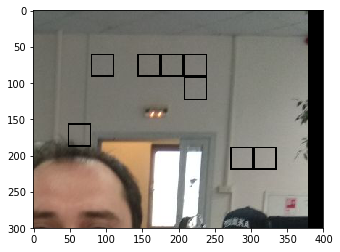

In [46]:
plt.imshow(Image.fromarray(out_img).crop((400,100, 800, 400)))

In [64]:
img, found = img_predict(path, 'book.jpg')

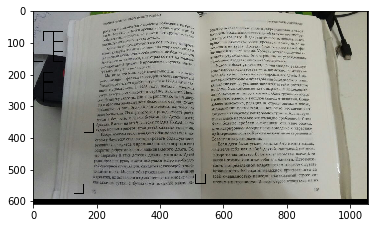

In [65]:
plt.imshow(img)

In [66]:
found

[[0, 128],
 [32, 64],
 [32, 192],
 [32, 224],
 [32, 256],
 [64, 64],
 [64, 96],
 [64, 128],
 [128, 544],
 [160, 352],
 [512, 512]]

In [72]:
img, hx, hy = set_random_gb(Image.open(os.path.join(path, 'book.jpg')))
hx, hy

(416, 256)

In [73]:
img, found = img_predict(path, 'book.jpg', hx, hy)

4.7893987 0


In [75]:
(hx, hy), found

((416, 256),
 [[0, 128],
  [32, 64],
  [32, 192],
  [32, 224],
  [32, 256],
  [64, 64],
  [64, 96],
  [64, 128],
  [128, 544],
  [160, 352],
  [512, 512]])

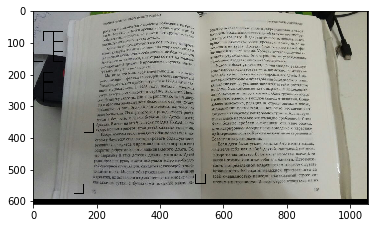

In [71]:
plt.imshow(img);

In [23]:
outp = mm(torch.tensor([images[100]], dtype=torch.float))

In [29]:
outp.detach().cpu().numpy()

array([[-0.2761525 ,  0.28809124]], dtype=float32)

In [24]:
_, pred = torch.max(outp, 1)

In [25]:
pred, _

(tensor([ 1], device='cuda:0'), tensor([ 0.2881], device='cuda:0'))

In [26]:
outp

tensor([[-0.2762,  0.2881]], device='cuda:0')